# Bias Correction and Downscaling Pipeline
This notebook performs:
- Bias correction of GEOS PM2.5 fields using DNN models
- Downscaling of corrected fields
- Visualization of results


## 1. Imports & Configuration

In [2]:
import pandas as pd # For data manipulation and analysis
import numpy as np # For numerical operations
import warnings # To manage warnings
import os, sys # For interacting with the operating system and runtime environment
import matplotlib.pyplot as plt # For creating static, interactive, and animated visualizations
import matplotlib as mpl # The core plotting library
import keras as k # For building and training neural networks
import keras.losses # For custom loss functions in Keras
import cartopy # For geospatial data processing and plotting
import cartopy.crs as ccrs # For coordinate reference systems in Cartopy
import xarray as xr # For working with labeled multi-dimensional arrays
import glob # For finding pathnames matching a specified pattern
from copy import deepcopy as dc # For creating deep copies of objects
import cartopy.feature as cfeature # For adding geographical features to maps
import time # For time-related functions
import re, urllib, requests, shutil, glob, json, logging
from pathlib import Path
from datetime import datetime, timedelta
import xarray as xr

warnings.filterwarnings('ignore') # Ignore warning messages
pd.set_option('display.float_format', lambda x: '%.5f' % x) # Set pandas display option for float format

## 2. Utility Functions

In [3]:
# Index of Agreement
def IOA(o, p):
    """
    Calculates the Index of Agreement (IOA) between observed and predicted values.

    Args:
        o (numpy.ndarray or list): Observed values.
        p (numpy.ndarray or list): Predicted values.

    Returns:
        float: The Index of Agreement.
    """
    ia = 1 -(np.sum((o-p)**2))/(np.sum((np.abs(p-np.mean(o))+np.abs(o-np.mean(o)))**2))
    return ia

# Customized Keras loss
def customLoss1(o, p):
    """
    Custom Keras loss function based on the negative of the Index of Agreement.

    Args:
        o (tf.Tensor): Observed values.
        p (tf.Tensor): Predicted values.

    Returns:
        tf.Tensor: The negative of the Index of Agreement.
    """
    ioa = 1 -(k.sum((o-p)**2))/(k.sum((k.abs(p-k.mean(o))+k.abs(o-k.mean(o)))**2))
    return (-ioa)

keras.losses.customLoss1 = customLoss1

# Normalize columns between 0 & 1
def normalize(DF, mx, mn):
    """
    Normalizes columns of a pandas DataFrame between 0 and 1.

    Args:
        DF (pandas.DataFrame): The DataFrame to normalize.
        mx (pandas.Series): Maximum values for each column.
        mn (pandas.Series): Minimum values for each column.

    Returns:
        pandas.DataFrame: The normalized DataFrame.
    """
    range1 = (mx.values - mn.values)
    d = pd.DataFrame(((DF.values - mn.values)/range1),
                     columns=DF.columns, index=DF.index)
    return d

def trim_to_multiple(ds, dim, multiple):
        """
        Trims a dimension of an xarray Dataset to be a multiple of a given number.

        Args:
            ds (xarray.Dataset): The input Dataset.
            dim (str): The name of the dimension to trim.
            multiple (int): The number the dimension size should be a multiple of.

        Returns:
            xarray.Dataset: The trimmed Dataset.
        """
        size = ds.dims[dim] # Get the size of the specified dimension
        remainder = size % multiple # Calculate the remainder
        if remainder == 0: # If the size is already a multiple, return the original dataset
            return ds
        # trim evenly from both sides
        trim_total = remainder # Total number of elements to trim
        trim_start = trim_total // 2 # Number of elements to trim from the start
        trim_end = trim_total - trim_start # Number of elements to trim from the end
        return ds.isel({dim: slice(trim_start, size - trim_end)}) # Return the trimmed dataset


def download_geos_data(date_str):
    """
    Download GEOS-FP data for given date (YYYYMMDD).
    If NetCDF already exists in config['temp_path'], skip entire process.
    Otherwise:
      - Skip downloading files that already exist
      - Still perform combine and join steps
    Returns path to combined NetCDF file.
    """

    print(f"Starting GEOS download process for {date_str}...")

    # ---------------------------
    # Step 1: Date setup
    # ---------------------------
    
    try:
        currentYear  = date_str[:4]
        currentMonth = date_str[4:6]
        currentDay   = date_str[6:8]
        
        #date_obj     = datetime.strptime(date_str, "%Y%m%d")
        
        #yesterday    = date_obj - timedelta(days=1)

        date_obj   = pd.to_datetime(date_str, format="%Y%m%d")
        yesterday  = date_obj - pd.Timedelta(days=1)
        yDay         = yesterday.strftime("%Y%m%d")
    except Exception as e:
        print(f"ERROR: Invalid date {date_str} — must be YYYYMMDD",e)
        raise e

    # ---------------------------
    # Step 2: Check existing output
    # ---------------------------
    out_file = os.path.join(wd+config["temp_path"], f"{date_str}.nc")
    if os.path.exists(out_file):
        print(f"Final NetCDF already exists for {date_str}: {out_file}")
        return out_file
    else:
        print(f"NetCDF not found for {date_str}, will proceed with processing.")

    # ---------------------------
    # Step 3: Setup directories
    # ---------------------------
    url = f"{config['url']}/Y{currentYear}/M{currentMonth}/D{currentDay}/H00/"
    direc3 = os.path.join(wd+config["threeHourDataPath"], currentYear, currentMonth, currentDay)
    direc1 = os.path.join(wd+config["oneHourDataPath"], currentYear, currentMonth, currentDay)
    combined1 = wd+config["combinedDataPath1hour"]
    combined3 = wd+config["combinedDataPath3hour"]

    for d in [direc3, direc1, combined1, combined3,
              wd+config["temp_path"]]:
        os.makedirs(d, exist_ok=True)

    print("Directories checked/created.")

    # ---------------------------
    # Step 4: Fetch file listing
    # ---------------------------
    def find_files():
        try:
            print(f"Connecting to {url} ...")
            HTML_TAG_REGEX = re.compile(r'<a[^<>]+?href=([\'\"])(.*?)\1', re.IGNORECASE)
            atags = [m[1] for m in HTML_TAG_REGEX.findall(requests.get(url, timeout=60).text)]
            links = sorted([a for a in atags if "GEOS.fp.fcst" in a])
            print(f"Found {len(links)} candidate files on server.")
            return links
        except Exception as e:
            print("ERROR: Failed to fetch file listing.")
            raise e

    # ---------------------------
    # Step 5: Download files (skip existing)
    # ---------------------------
    def download_files(links):
        downloaded, skipped = 0, 0
        count3, count1 = 0, 0  # separate counters
        index1=0

        for link in links:
            try:
                # 3-hour aerosol
                if 'tavg3_2d_aer_Nx' in link and yDay+'_2230' not in link:
                    if count3 < 24:
                        target = os.path.join(direc3, link)
                        if not os.path.exists(target):
                            print(f"Downloading (3h) {link} ...")
                            r = requests.get(url+link, timeout=60)
                            with open(target, 'wb') as f: f.write(r.content)
                            downloaded += 1
                        else:
                            skipped += 1
                        count3 += 1

                # 1-hour meteorology (every 3rd file)

                if 'tavg1_2d_slv_Nx' in link and f"{date_str}_0030" not in link:
                    if index1 % 3 == 0 and count1 < 24:
                        target = os.path.join(direc1, link)
                        if not os.path.exists(target):
                            print(f"Downloading (1h) {link} ...")
                            r = requests.get(url+link, timeout=60)
                            with open(target, 'wb') as f:
                                f.write(r.content)
                            downloaded += 1
                        else:
                            skipped += 1
                        count1 += 1
                    index1 += 1   # advance index for each 1h file seen

                # Stop early if both limits reached
                if count3 >= 24 and count1 >= 24:
                    print("Reached 24 files each for 3h and 1h, stopping download.")
                    break
            except Exception as e:
                print(f"ERROR downloading {link}: {e}")
        print(f"Download summary: {downloaded} new, {skipped} skipped.")

    # ---------------------------
    # Step 6: Combine and join
    # ---------------------------
    def process_1hour(ds): return xr.open_dataset(ds['lat'].encoding['source'])[config["oneHourKeepVariables"]]
    def process_3hour(ds): return xr.open_dataset(ds['lat'].encoding['source'])[config["threeHourKeepVariables"]]

    def combine_data(path, outfile, preprocess):
        files = sorted(glob.glob(path+"/*"))
        if len(files) == 0:
            raise Exception(f"No files in {path} to combine!")
        print(f"Combining {len(files)} files into {outfile} ...")
        xd = xr.open_mfdataset(files, preprocess=preprocess)
        xd.to_netcdf(outfile)
        print(f"Combined file saved: {outfile}")

    def join_data(in1, in3, out):
        print(f"Joining {in1} + {in3} → {out}")
        ds1, ds2 = xr.open_dataset(in1), xr.open_dataset(in3)
        ds_merged = xr.merge([ds1, ds2])
        ds_merged.to_netcdf(out)
        print(f"Final joined NetCDF saved: {out}")

    # ---------------------------
    # Step 7: Run workflow
    # ---------------------------
    links = find_files()
    download_files(links)  # Will skip existing files but continue

    f1 = os.path.join(combined1, f"{date_str}.nc")
    f3 = os.path.join(combined3, f"{date_str}.nc")

    combine_data(direc1, f1, process_1hour)
    combine_data(direc3, f3, process_3hour)
    join_data(f1, f3, out_file)

    print(f"Completed GEOS download + processing for {date_str}")
    return out_file

## 3. Bias Correction Function


In [4]:
def bias_correction(fn):
    """
    Performs bias correction of GEOS PM2.5 fields using DNN models.

    Args:
        fn (str): Path to the input NetCDF file.

    Returns:
        xarray.Dataset: The bias-corrected xarray Dataset.
    """
    # Load and subset data based on user-defined latitude and longitude bounds
    #ds = xr.open_dataset(fn).sel(lat=slice(-11.25,28.5), lon=slice(91.8,141.6))
    ds = xr.open_dataset(fn).sel(lat=slice(*user_inputs["lat_bounds"]),
                             lon=slice(*user_inputs["lon_bounds"]))
    # Ensure dimensions are multiples of 40
    lat_size = ds.dims["lat"]
    lon_size = ds.dims["lon"]

    print (lat_size,lon_size)

    # Apply trimming for both lat and lon
    ds = trim_to_multiple(ds, "lat", 40)
    ds = trim_to_multiple(ds, "lon", 40)
    lat_size = ds.dims["lat"]
    lon_size = ds.dims["lon"]

    print (lat_size,lon_size)

    # Convert to pandas DataFrame for easier manipulation
    df = ds.to_dataframe().reset_index()

    # Unit conversions
    df.NISMASS25 = df['NISMASS25']*1e9
    df.OCSMASS   = df['OCSMASS']*1e9
    df.SO2SMASS  = df['SO2SMASS']*1e9
    df.SO4SMASS  = df['SO4SMASS']*1e9
    df.SSSMASS25 = df['SSSMASS25']*1e9
    df.DUSMASS25 = df['DUSMASS25']*1e9
    df.BCSMASS   = df['BCSMASS']*1e9

    # Calculate GEOS PM25
    df['GEOSPM25'] = (df.DUSMASS25 + df.SSSMASS25 + df.NISMASS25 +
                      df.BCSMASS + (df.OCSMASS * 1.6) + (df.SO4SMASS * 1.375))

    # Calculate wind speed
    df['WIND'] = (df['U10M']**2 + df['V10M']**2)**0.5
    # Dates
    date1 = (pd.to_datetime(fn[-11:-3])+pd.Timedelta(0,'D')).strftime('%Y%m%d')
    date2 = (pd.to_datetime(fn[-11:-3])+pd.Timedelta(1,'D')).strftime('%Y%m%d')
    date3 = (pd.to_datetime(fn[-11:-3])+pd.Timedelta(2,'D')).strftime('%Y%m%d')

    df["Date"] = df['time'].dt.strftime('%Y%m%d')
    # Create separate dataframes for each forecast day
    df1, df2, df3 = df[df.Date==date1], df[df.Date==date2], df[df.Date==date3]

    # Apply folds
    for fold in range(10):
        # Load day 1 model and predict
        with k.utils.custom_object_scope({'TFOpLambda': lambda x: x, 'customLoss1': customLoss1}):
            model1 = k.models.load_model(model_path+f"v1_4_dnn_bias_Correction_day1_fold{fold:02d}.h5")
        temp = normalize(df1[feature_columns], mx.T[feature_columns], mn.T[feature_columns])
        temp[temp<0] = np.nan
        df1[f"DNN_{fold:02d}"] = model1.predict(temp, steps=2, verbose=1)

        # Load day 2 model and predict
        with k.utils.custom_object_scope({'TFOpLambda': lambda x: x, 'customLoss1': customLoss1}):
            model2 = k.models.load_model(model_path+f"v1_4_dnn_bias_Correction_day2_fold{fold:02d}.h5")
        temp = normalize(df2[feature_columns], mx.T[feature_columns], mn.T[feature_columns])
        temp[temp<0] = np.nan
        df2[f"DNN_{fold:02d}"] = model2.predict(temp, steps=2, verbose=1)

        # Load day 3 model and predict
        with k.utils.custom_object_scope({'TFOpLambda': lambda x: x, 'customLoss1': customLoss1}):
            model3 = k.models.load_model(model_path+f"v1_4_dnn_bias_Correction_day3_fold{fold:02d}.h5")
        temp = normalize(df3[feature_columns], mx.T[feature_columns], mn.T[feature_columns])
        temp[temp<0] = np.nan
        df3[f"DNN_{fold:02d}"] = model3.predict(temp, steps=2, verbose=1)

    # Ensemble models
    for i, (dfx, day) in enumerate(zip([df1, df2, df3],[1,2,3])):
        # Load ensemble model for the current day
        with k.utils.custom_object_scope({'TFOpLambda': lambda x: x, 'customLoss1': customLoss1}):
            model = k.models.load_model(model_path+f"v1_4_day{day}_dnn_bias_Correction_ensemble.h5")
        # Normalize features for the ensemble model
        temp = normalize(dfx[feature_columns2], mx.T[feature_columns2], mn.T[feature_columns2])
        temp[temp<0] = np.nan
        # Predict bias-corrected PM2.5 using the ensemble model
        dfx["BC_DNN_PM25"] = model.predict(temp, steps=2, verbose=0)

    # Concatenate the daily dataframes and select output columns
    df = pd.concat((df1,df2,df3), axis=0)[out_cols]
    # Set index and convert back to xarray Dataset
    out_df = df.set_index(['lat', 'lon', 'time'])
    out_xarray = xr.Dataset.from_dataframe(out_df).astype("float32")

    # Save the bias-corrected data to a NetCDF file
    out_xarray.to_netcdf(out_bc_path+outfn_bc, mode='w', format='NETCDF4',
        encoding={'lat':{"_FillValue":None,'zlib':True,'dtype':'float32'},
                  'lon':{"_FillValue":None,'zlib':True,'dtype':'float32'},
                  'GEOSPM25':{"_FillValue":-999,'zlib':True,'dtype':'float32'},
                  'BC_DNN_PM25':{"_FillValue":-999,'zlib':True,'dtype':'float32'}})
    return out_xarray

## 4. Downscaling Function


In [5]:
def downscale(ds):
    """
    Downscales GEOS PM2.5 and bias-corrected PM2.5 fields using a downscaling model.

    Args:
        ds (xarray.Dataset): The input xarray Dataset containing GEOS and bias-corrected PM2.5.

    Returns:
        xarray.Dataset: The downscaled xarray Dataset.
    """
    #with k.utils.custom_object_scope({'TFOpLambda': lambda x: x, 'customLoss1': customLoss1}):
     #   model = k.models.load_model(model_path+"model_downscale_v1.h5")

    # Load the downscaling model with custom objects
    keras.losses.customLoss1 = customLoss1
    model = keras.models.load_model(wd + "/Model/model_downscale_v1.h5",custom_objects={'customLoss1': customLoss1})

    # Define the high-resolution grid for downscaling
    lat = np.arange((ds.lat.min()-0.1),(ds.lat.max()+0.15),0.05)
    lon = np.arange((ds.lon.min()-0.125),(ds.lon.max()+0.1875),0.0625)

    # GEOS downscaling
    pm25 = np.moveaxis(ds['GEOSPM25'].values, -1, 0) # Rearrange dimensions for model input
    geos = np.moveaxis(model.predict(dc(pm25), steps=1, verbose=1)[:,:,:,0], 0, -1) # Predict and rearrange output

    # Bias corrected downscaling
    pm25 = np.moveaxis(ds['BC_DNN_PM25'].values, -1, 0) # Rearrange dimensions for model input
    dnn = np.moveaxis(model.predict(dc(pm25), steps=1, verbose=1)[:,:,:,0], 0, -1) # Predict and rearrange output

    # Create the output xarray Dataset
    out_ds = xr.Dataset(
        data_vars=dict(
            DS_GEOSPM25=(["lat","lon","time"], geos), # Downscaled GEOS PM2.5
            DS_BC_DNN_PM25=(["lat","lon","time"], dnn), # Downscaled Bias Corrected PM2.5
        ),
        coords=dict(
            lon=(["lon"], lon), # High-resolution longitude
            lat=(["lat"], lat), # High-resolution latitude
            time=ds['time'], # Time coordinates from input
        ),
        attrs=dict(description="Downscaled PM2.5"), # Dataset attributes
    )

    # Save the downscaled data to a NetCDF file
    out_ds.to_netcdf(out_ds_path+outfn_ds, mode='w', format='NETCDF4',
        encoding={'lat':{"_FillValue":None,'zlib':True,'dtype':'float32'},
                  'lon':{"_FillValue":None,'zlib':True,'dtype':'float32'},
                  'DS_GEOSPM25':{"_FillValue":-999,'zlib':True,'dtype':'float32'},
                  'DS_BC_DNN_PM25':{"_FillValue":-999,'zlib':True,'dtype':'float32'}})

    return out_ds # Return the downscaled dataset

## 5. Plotting Function


In [6]:
def PLOT_DS(ds, out_ds, imgs=8):
    """
    Plots downscaled and bias-corrected PM2.5 fields.

    Args:
        ds (xarray.Dataset): The input xarray Dataset (25km resolution).
        out_ds (xarray.Dataset): The downscaled xarray Dataset (5km resolution).
        imgs (int, optional): The number of time steps to plot. Defaults to 8.
    """
    # Get latitude and longitude values for both resolutions
    lat_25km, lon_25km = ds.lat.values, ds.lon.values
    lat_5km, lon_5km = out_ds.lat.values, out_ds.lon.values

    # Loop through the specified number of time steps
    for i in range(imgs):
        # Extract data for the current time step for both resolutions
        geos_25km_data = ds['GEOSPM25'].values[:, :, i]
        dnn_25km_data = ds['BC_DNN_PM25'].values[:, :, i]
        geos_5km_data = out_ds['DS_GEOSPM25'].values[:, :, i]
        dnn_5km_data = out_ds['DS_BC_DNN_PM25'].values[:, :, i]

        # Get and format dates for titles and filenames
        initialization_date = pd.to_datetime(ds.time[0].values).strftime("%Y-%m-%d %H:%M")
        forecast_date = pd.to_datetime(ds.time[i].values).strftime("%Y-%m-%d %H:%M")
        filename_date = pd.to_datetime(ds.time[i].values).strftime("%Y%m%d_%H%M")

        # Determine the output path based on the day
        if i < 8:
            plot_path = plots + "/Day1/"
        elif i >= 16:
            plot_path = plots + "/Day3/"
        else:
            plot_path = plots + "/Day2/"

        # Create figure and subplots with a specified projection
        fig, axs = plt.subplots(2, 2, figsize=(60, 50),
                                subplot_kw={'projection': projection}, frameon=True)
        # Add a super title to the figure
        fig.suptitle(f"Initialization Date:{initialization_date}\nForecast Date:{forecast_date}",
                     fontsize=60, fontweight='bold', y=.94)

        # Define plot titles and corresponding data
        plot_configs = [
            {'ax': axs[0, 0], 'data': geos_25km_data, 'title': 'GEOS 25km', 'lat': lat_25km, 'lon': lon_25km},
            {'ax': axs[0, 1], 'data': dnn_25km_data, 'title': 'Bias Corrected 25km', 'lat': lat_25km, 'lon': lon_25km},
            {'ax': axs[1, 0], 'data': geos_5km_data, 'title': 'GEOS 5km', 'lat': lat_5km, 'lon': lon_5km},
            {'ax': axs[1, 1], 'data': dnn_5km_data, 'title': 'Bias Corrected 5km', 'lat': lat_5km, 'lon': lon_5km}
        ]

        # Loop through each subplot configuration and plot the data
        for config in plot_configs:
            ax = config['ax']
            data = config['data']
            title = config['title']
            lat_coords = config['lat']
            lon_coords = config['lon']

            # Create pseudocolor plot
            cm = ax.pcolor(lon_coords, lat_coords, data,
                           cmap=cmap,
                           transform=ccrs.PlateCarree(),
                           norm=norm)
            # Add geographical features
            ax.coastlines(resolution='50m')
            ax.add_feature(cfeature.COASTLINE)
            ax.add_feature(cfeature.BORDERS)
            ax.add_feature(cfeature.NaturalEarthFeature(
                category='cultural', name='admin_1_states_provinces_lines',
                scale='50m', facecolor='none'))
            # Set subplot title
            ax.set_title(title, fontsize=50, fontweight="bold")

        # Adjust spacing between subplots
        plt.subplots_adjust(wspace=0.0, hspace=0.1)
        # Add colorbar
        cax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0, 0.01, ax.get_position().height * 2.1])
        plt.colorbar(cm, cax=cax, ticks=cbarticks)
        # Save the figure
        plt.savefig(plot_path + f"v1_4_{filename_date}.png", bbox_inches='tight')

## 6. Plot Settings


In [8]:
plt.rcParams.update({'font.size': 50}) # Update default font size for plots
projection = ccrs.PlateCarree() # Set the coordinate reference system to PlateCarree
cbarticks = list(np.arange(0,151,10)) + [200,500,1000] # Define tick values for the color bar
cmap = plt.cm.jet # Set the colormap to 'jet'
cmaplist = [cmap(i) for i in range(cmap.N)][50:] # Create a list of colors from the upper part of the 'jet' colormap
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N) # Create a custom colormap
norm = mpl.colors.BoundaryNorm(cbarticks, cmap.N) # Create a colormap normalization object with specified boundaries

## 7. Paths & File List


In [9]:
# Get current working directory
wd = os.getcwd()
print("Current working dir:", wd)
#wd = "your path"
#os.chdir(wd)
in_files_path = wd + "/IN_NetCDF/"
scalar_path   = wd + "/Scalars/"
out_bc_path   = wd + "/OUT_BC/"
out_ds_path   = wd + "/OUT_DS/"
model_path    = wd + "/Model/"
plots         = wd + "/PLOTS/"

Current working dir: /Users/asayeed/AQ_Downscaling


## 8. Global Parameters for Bias Correction


In [10]:
# Define the list of features used for the bias correction models
feature_columns = ['WIND','PS','Q500','QV10M','T10M','T500',
                   'U10M','V10M','BCSMASS','DUSMASS25',
                   'OCSMASS','SO2SMASS','SO4SMASS','SSSMASS25','TOTEXTTAU']

# Create a list of column names for the DNN fold predictions
cols = [f"DNN_{i:02d}" for i in range(10)]
# Combine original features with DNN fold prediction columns
feature_columns2 = feature_columns + cols

# Load max/min values for normalization from a CSV file
mx_mn = pd.read_csv(scalar_path+'max_min4.csv', index_col=0).T
# Manually set max/min for DNN prediction columns (assuming a range of 0-1000)
mx_mn.loc['mx', cols] = 1000.0
mx_mn.loc['mn', cols] = 0.0
# Extract max and min values as separate Series
mx, mn = mx_mn.loc['mx',:], mx_mn.loc['mn',:]

# Define the output columns to keep after bias correction
out_cols = ['lat','lon','time','GEOSPM25','BC_DNN_PM25']



## Recommended Latitude/Longitude Bounds

For best results with this pipeline, we recommend using the following **lat/lon bounds**:  

- **Latitude**: `-11.25 → 28.5`  
- **Longitude**: `91.8 → 141.6`  

These bounds ensure:
- Coverage of the target study region (South & Southeast Asia domain).  
- Array dimensions align well with model requirements (multiples of 40 after trimming).  
- Stable performance during bias correction and downscaling.

In [11]:
#Default Dates and bounds
user_date_str = "20250925"
(lat_min, lat_max) = (-11.25, 28.5)
(lon_min, lon_max) = (91.8, 141.6)
user_inputs = {
    "date": user_date_str,
    "lat_bounds": (lat_min, lat_max),
    "lon_bounds": (lon_min, lon_max)
}
user_inputs

{'date': '20250925', 'lat_bounds': (-11.25, 28.5), 'lon_bounds': (91.8, 141.6)}

In [ ]:
# Skip if you want to do a default run

import datetime

today = datetime.date.today()
min_date = today - datetime.timedelta(days=28)

print(f"Please enter a date between {min_date.strftime('%Y%m%d')} and {today.strftime('%Y%m%d')}")

while True:
    user_date_str = input("Enter date in YYYYMMDD format (e.g., 20250910): ")

    try:
        # Parse input date string into a datetime object
        user_date = datetime.datetime.strptime(user_date_str, "%Y%m%d").date()

        # Calculate the difference in days between today and the user's date
        delta_days = (today - user_date).days

        # Validate the date: must not be in the future and within the last 28 days
        if delta_days < 0:
            print("Date cannot be in the future. Try again.")
        elif delta_days > 28:
            print("Date is older than 28 days. Please provide a recent date.")
        else:
            print(f"Date accepted: {user_date_str} (within {delta_days} days).")

            # Build file list (commented out in original code)
            #flist = sorted(glob.glob(in_files_path + f"{user_date_str}*"))
            #if len(flist) == 0:
             #   print(f"No input files found for {user_date_str} in {in_files_path}. Try another date.")
            #else:
            #    print(f"Found {len(flist)} file(s) for date {user_date_str}")
            break  # exit loop if everything is valid
    except Exception as e:
        # Handle invalid date format input
        print("Invalid format. Please use YYYYMMDD (e.g., 20250910).")


# ---------------------------
# Lat/Lon bounds validation
# ---------------------------
while True:
    try:
        # Get latitude and longitude input from the user
        lat_min = float(input("Enter minimum latitude (-90 to 90): "))
        lat_max = float(input("Enter maximum latitude (-90 to 90): "))
        lon_min = float(input("Enter minimum longitude (-180 to 180): "))
        lon_max = float(input("Enter maximum longitude (-180 to 180): "))

        # Validate the latitude and longitude bounds
        if not (-90 <= lat_min < lat_max <= 90):
            print("Latitude bounds must be between -90 and 90, with lat_min < lat_max.")
        elif not (-180 <= lon_min < lon_max <= 180):
            print("Longitude bounds must be between -180 and 180, with lon_min < lon_max.")
        else:
            print(f"Lat/Lon bounds accepted: lat [{lat_min}, {lat_max}], lon [{lon_min}, {lon_max}]")
            break # Exit loop if bounds are valid
    except ValueError:
        # Handle non-numeric input for bounds
        print("Please enter valid numeric values for lat/lon bounds.")

# Store validated user inputs in a dictionary
user_inputs = {
    "date": user_date_str,
    "lat_bounds": (lat_min, lat_max),
    "lon_bounds": (lon_min, lon_max)
}

# Print the final collected inputs
print("Final inputs:", user_inputs)

In [12]:
# Flag to control whether plotting is enabled
PLOT = True#False#

imgs = 1 # No. of timesteps you want to plot. 

## 9. Main Loop


Input files found: ['/Users/asayeed/AQ_Downscaling/IN_NetCDF/20250925.nc']
160 160
160 160
1/1 [==============================] - 0s 74ms/step
20250925 Processing time: 35.55602169036865 secs


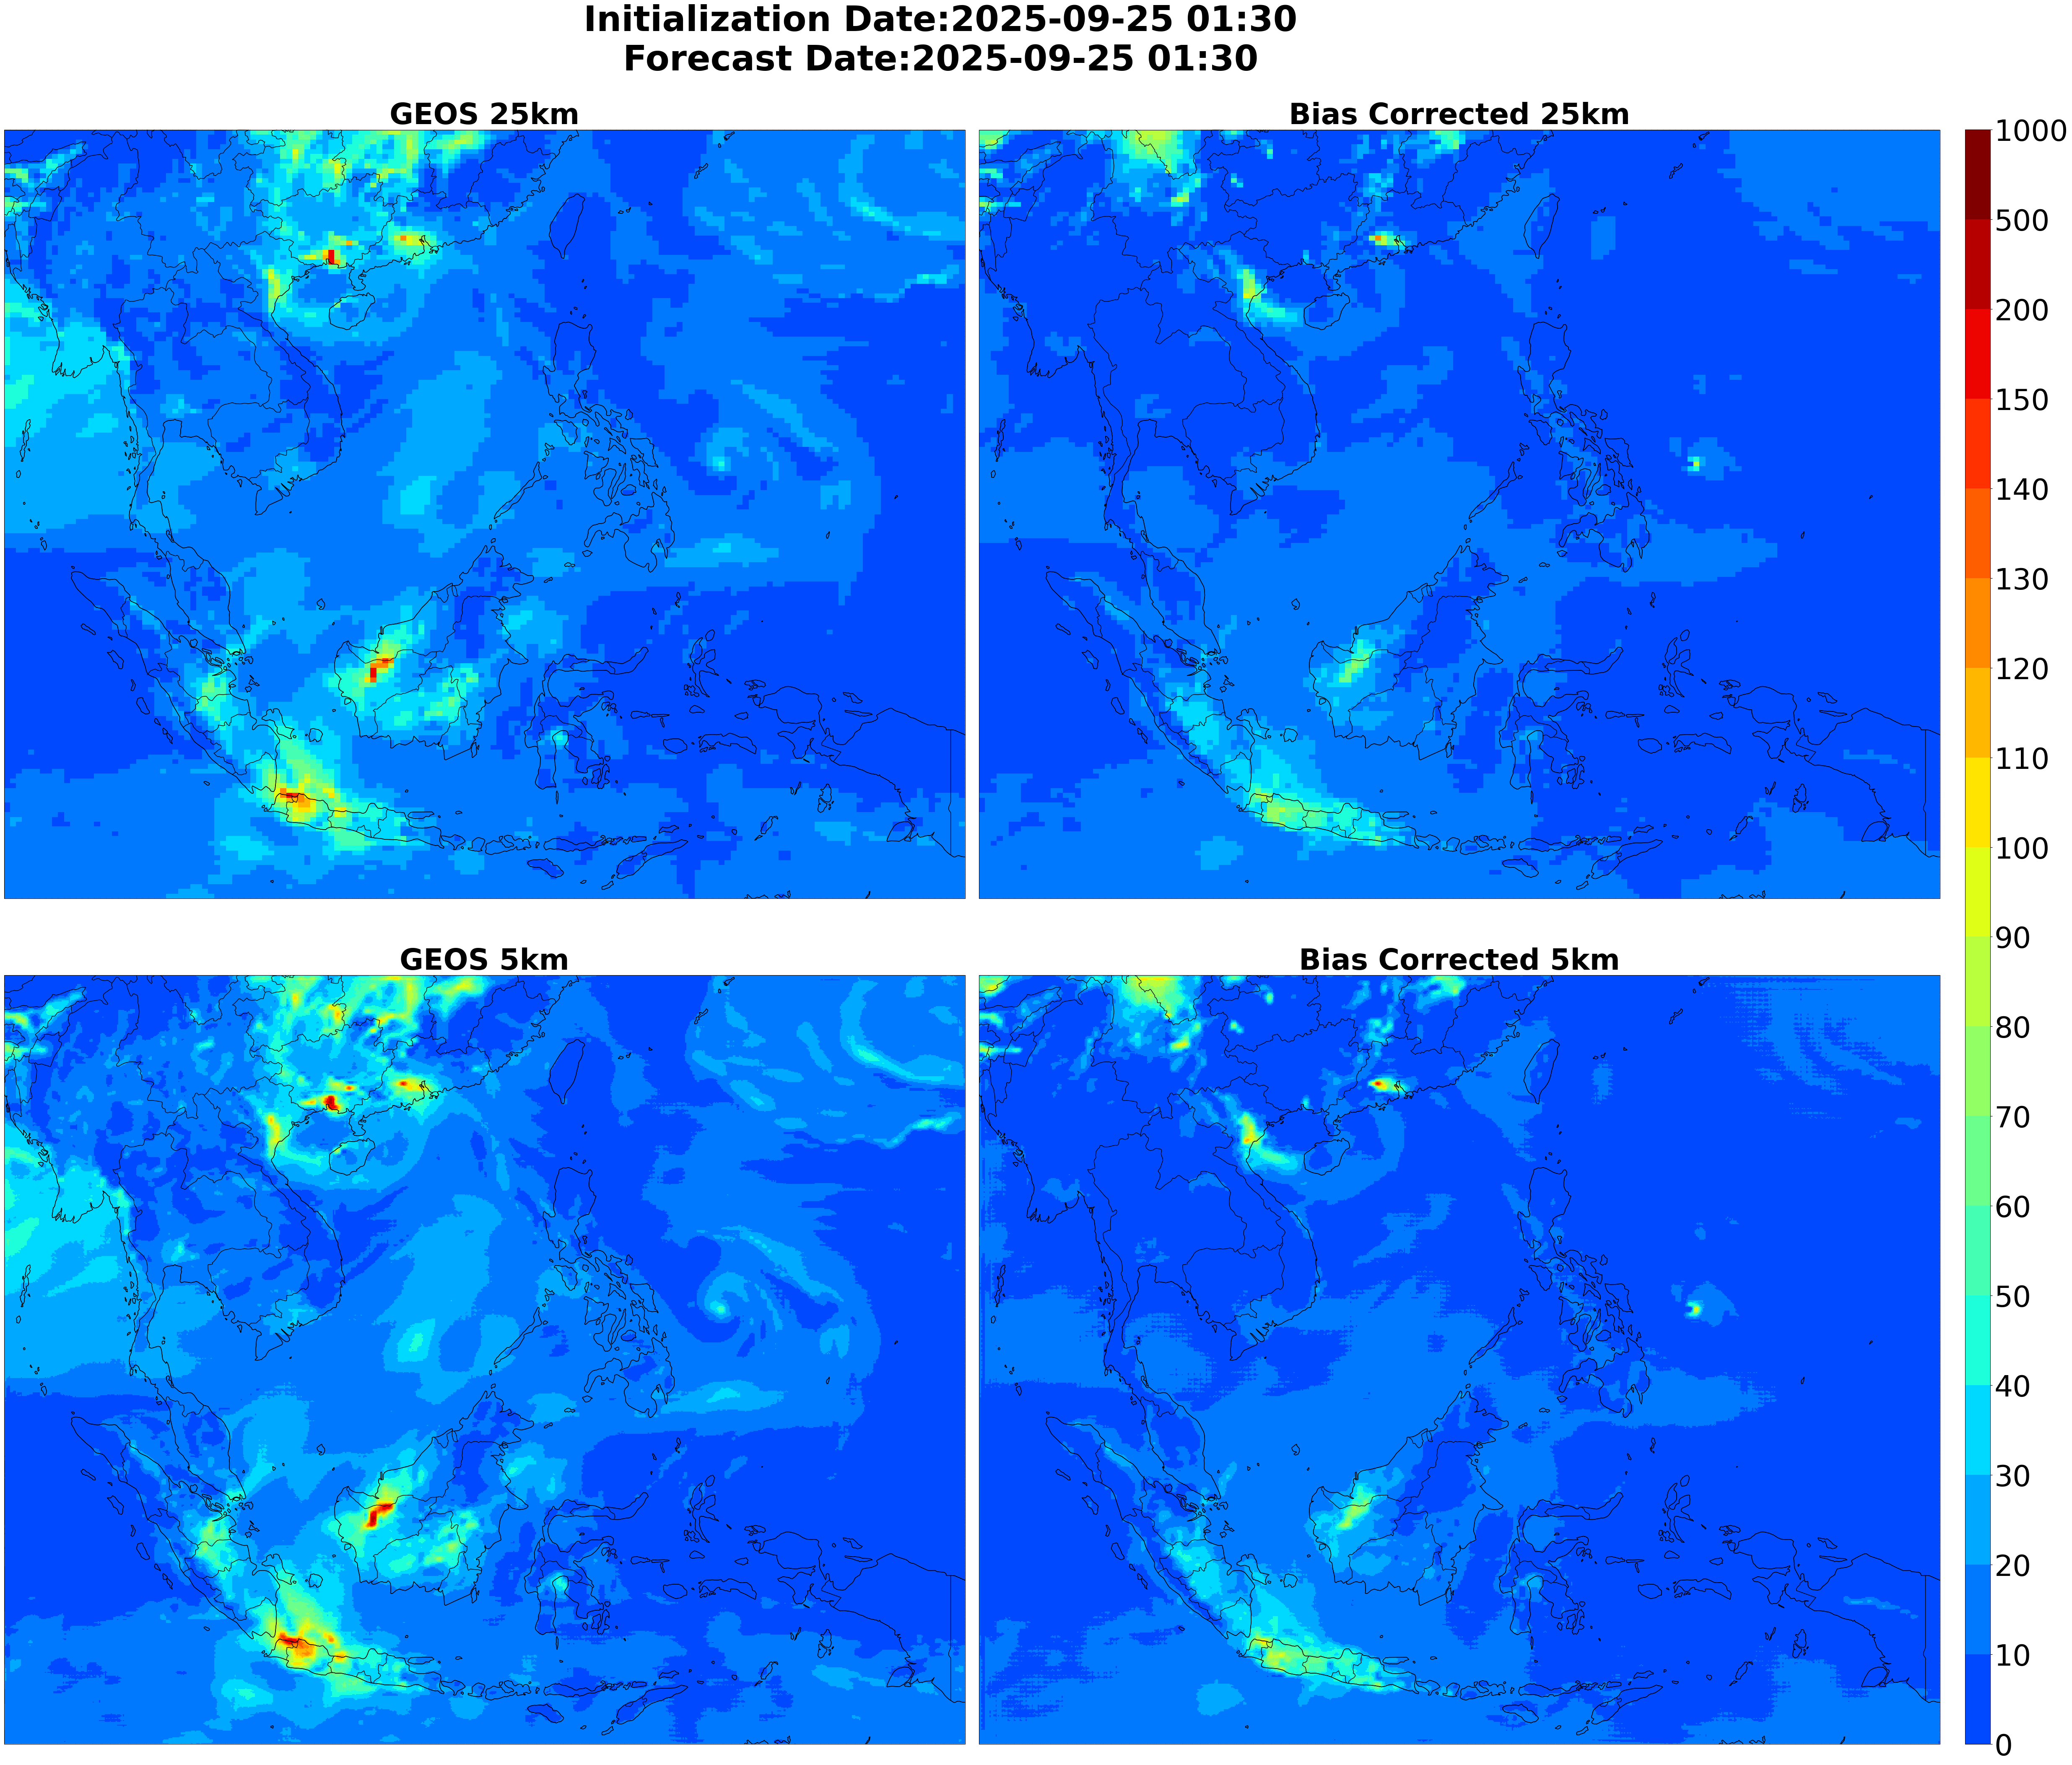

In [14]:
# Get the list of input files for the user-selected date
flist = sorted(glob.glob(in_files_path + user_inputs["date"] + "*"))
print("Input files found:", flist)

# If no files found, trigger GEOS download
if len(flist) == 0:
    print(f"No input files found for {user_inputs['date']} — starting download...")
    # Load params file (make sure you have it in Google Drive under base_dir)
    with open(wd + "/downloadGEOSDataParams.json") as f:
        config = json.load(f)

    # Setup logging
    if config["logMode"] == "DEBUG":
        logging.basicConfig(level=logging.DEBUG, filename=wd+config["logFile"], format='%(message)s')
    elif config["logMode"] == "INFO":
        logging.basicConfig(level=logging.INFO, filename=wd+config["logFile"], format='%(message)s')

    geos_file = download_geos_data(user_inputs["date"])
    # After download, rebuild the file list
    flist = sorted(glob.glob(in_files_path + user_inputs["date"] + "*"))
    print("Files after download:", flist)

lst = []  # Initialize an empty list (not used in this loop)

# Loop through each input file
for fn in flist:
    # Define output filenames for bias-corrected and downscaled data
    outfn_bc = "v1_4_BC_" + fn[-11:]
    outfn_ds = "v1_4_DS_" + fn[-11:]
    date = fn[-11:-3]  # Extract date from filename

    # Check if the downscaled output file already exists to avoid re-processing
    if not os.path.exists(out_ds_path + outfn_ds):
        try:
            t1 = time.time()  # Start timing the processing
            ds = bias_correction(fn)  # Perform bias correction
            out_ds = downscale(ds)    # Perform downscaling
            if PLOT:  # Check if plotting is enabled
                PLOT_DS(ds, out_ds,imgs=imgs)  # Generate plots
            print(date, "Processing time:", (time.time() - t1), "secs")
        except Exception as e:
            # Catch and print any errors that occur during processing
            exc_type, exc_obj, exc_tb = sys.exc_info()
            fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
            print(f"Error in {fname} at line {exc_tb.tb_lineno}: {e}")

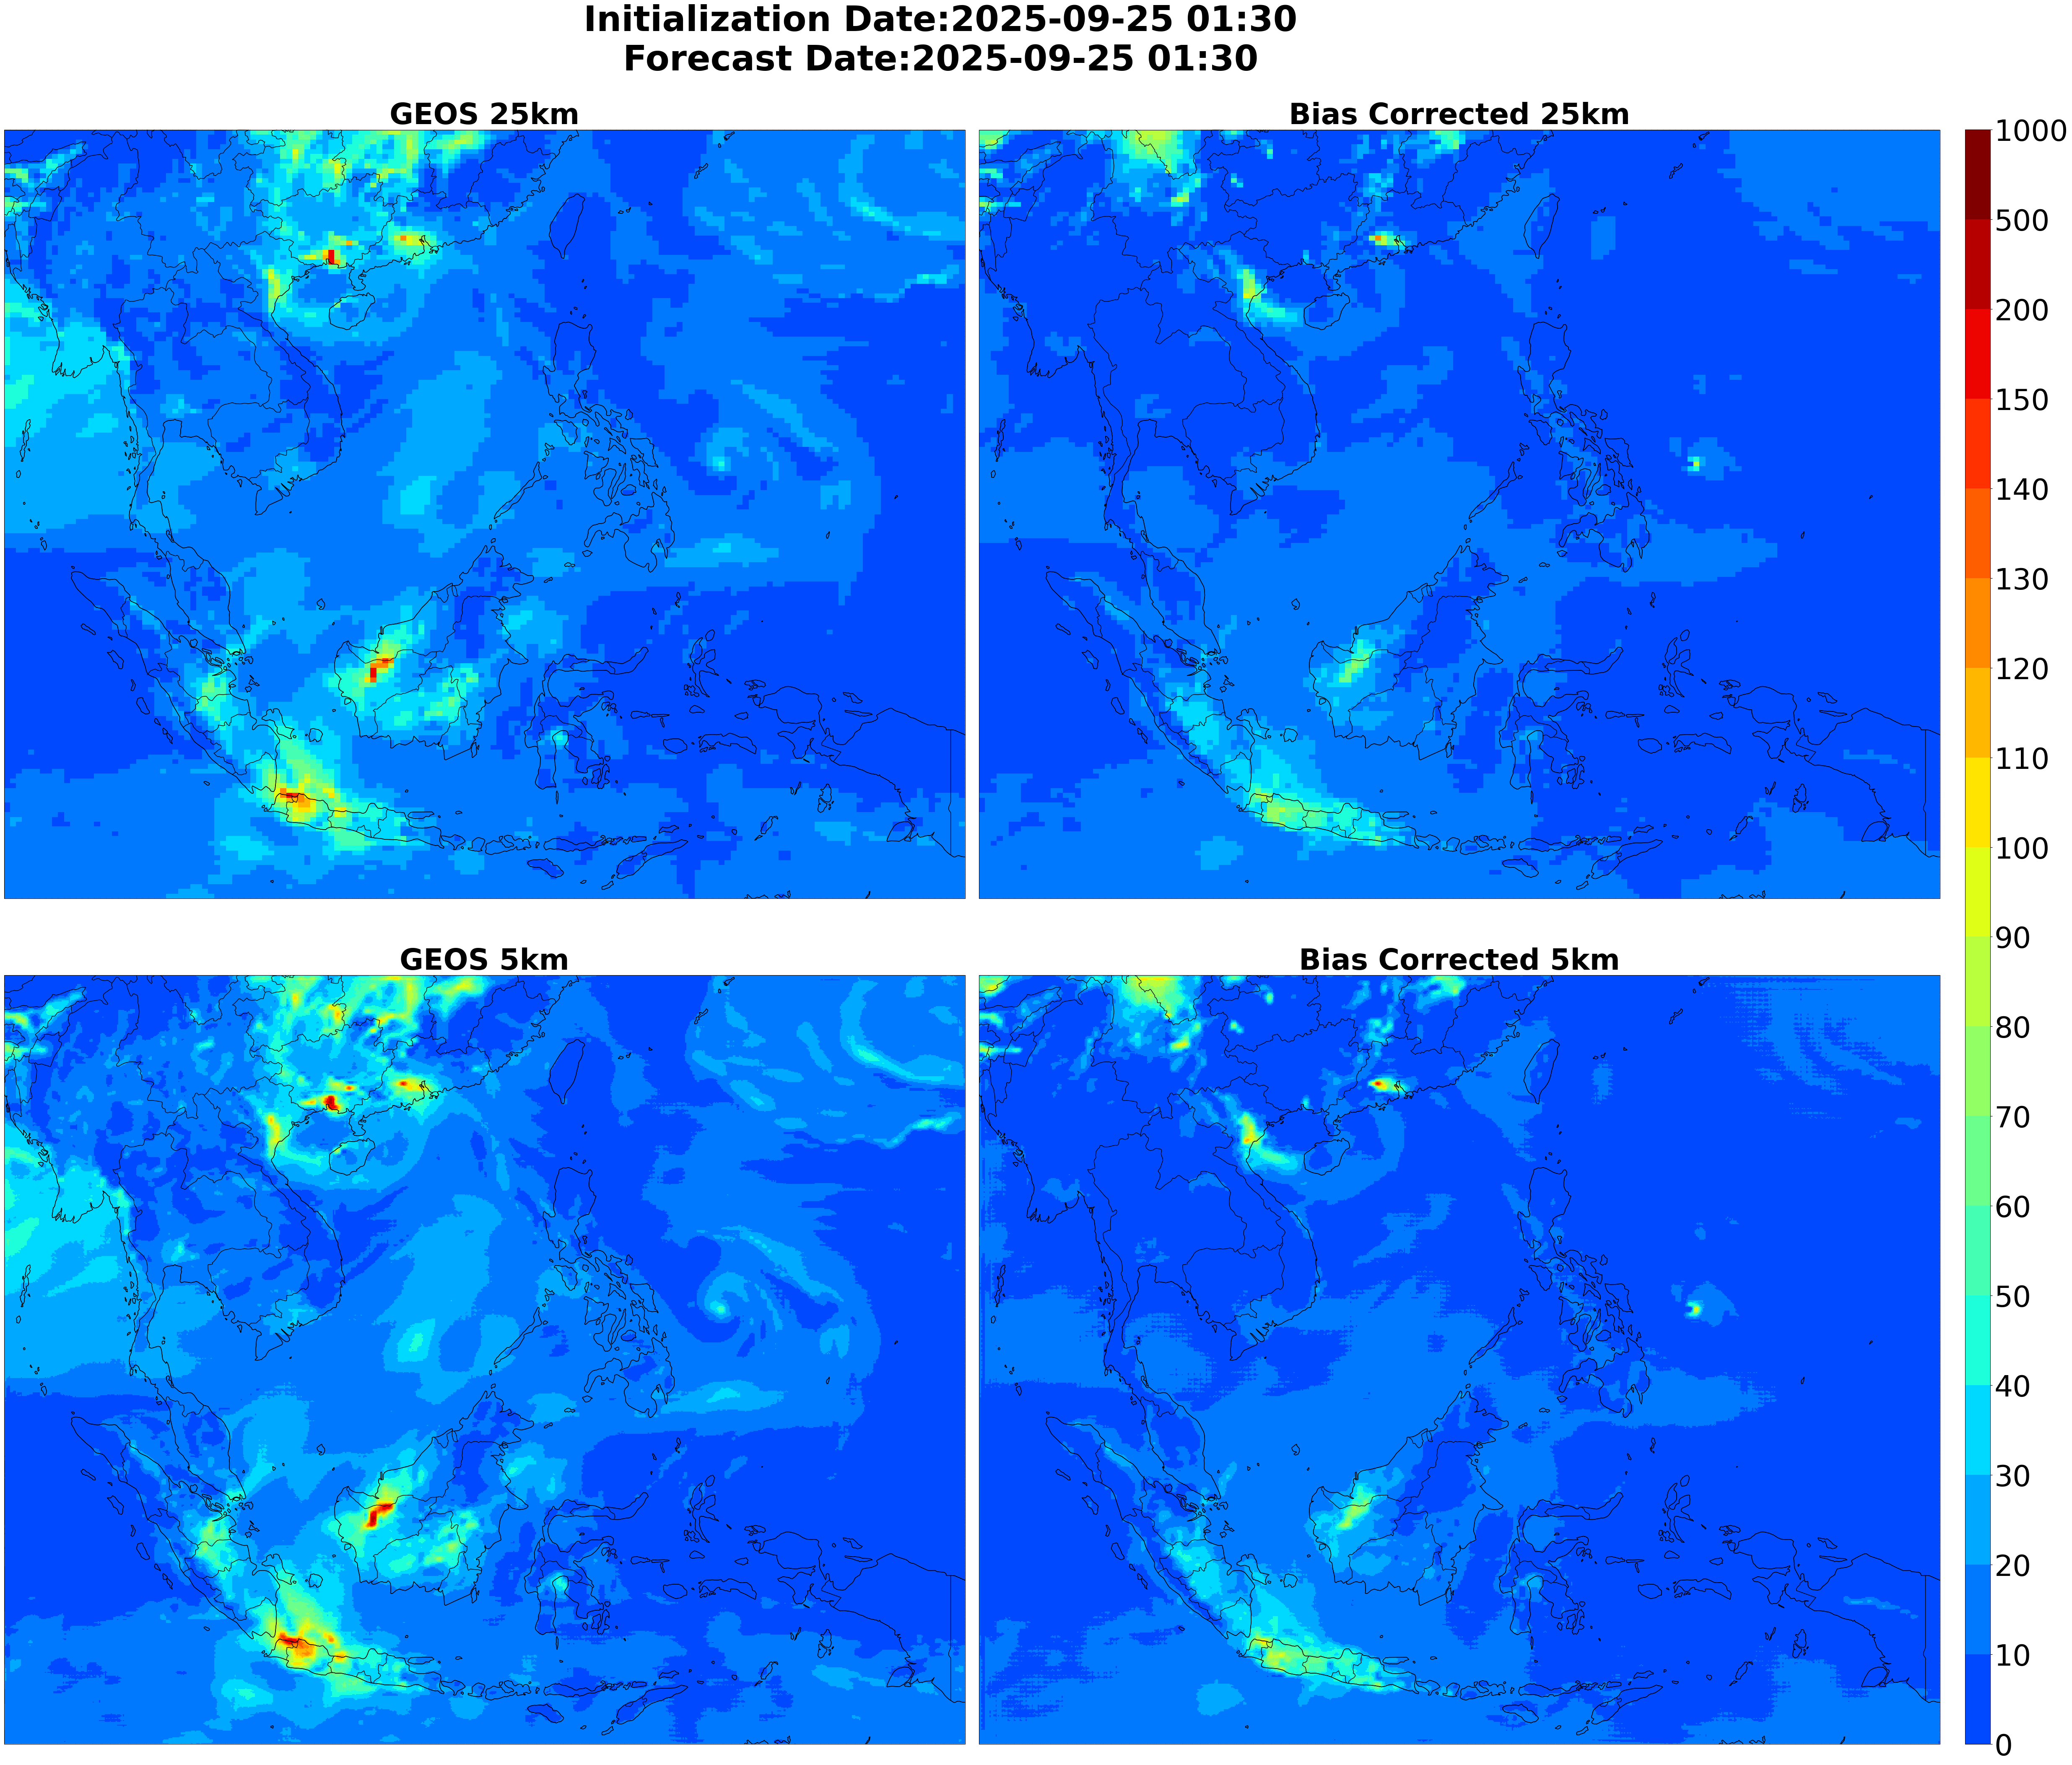

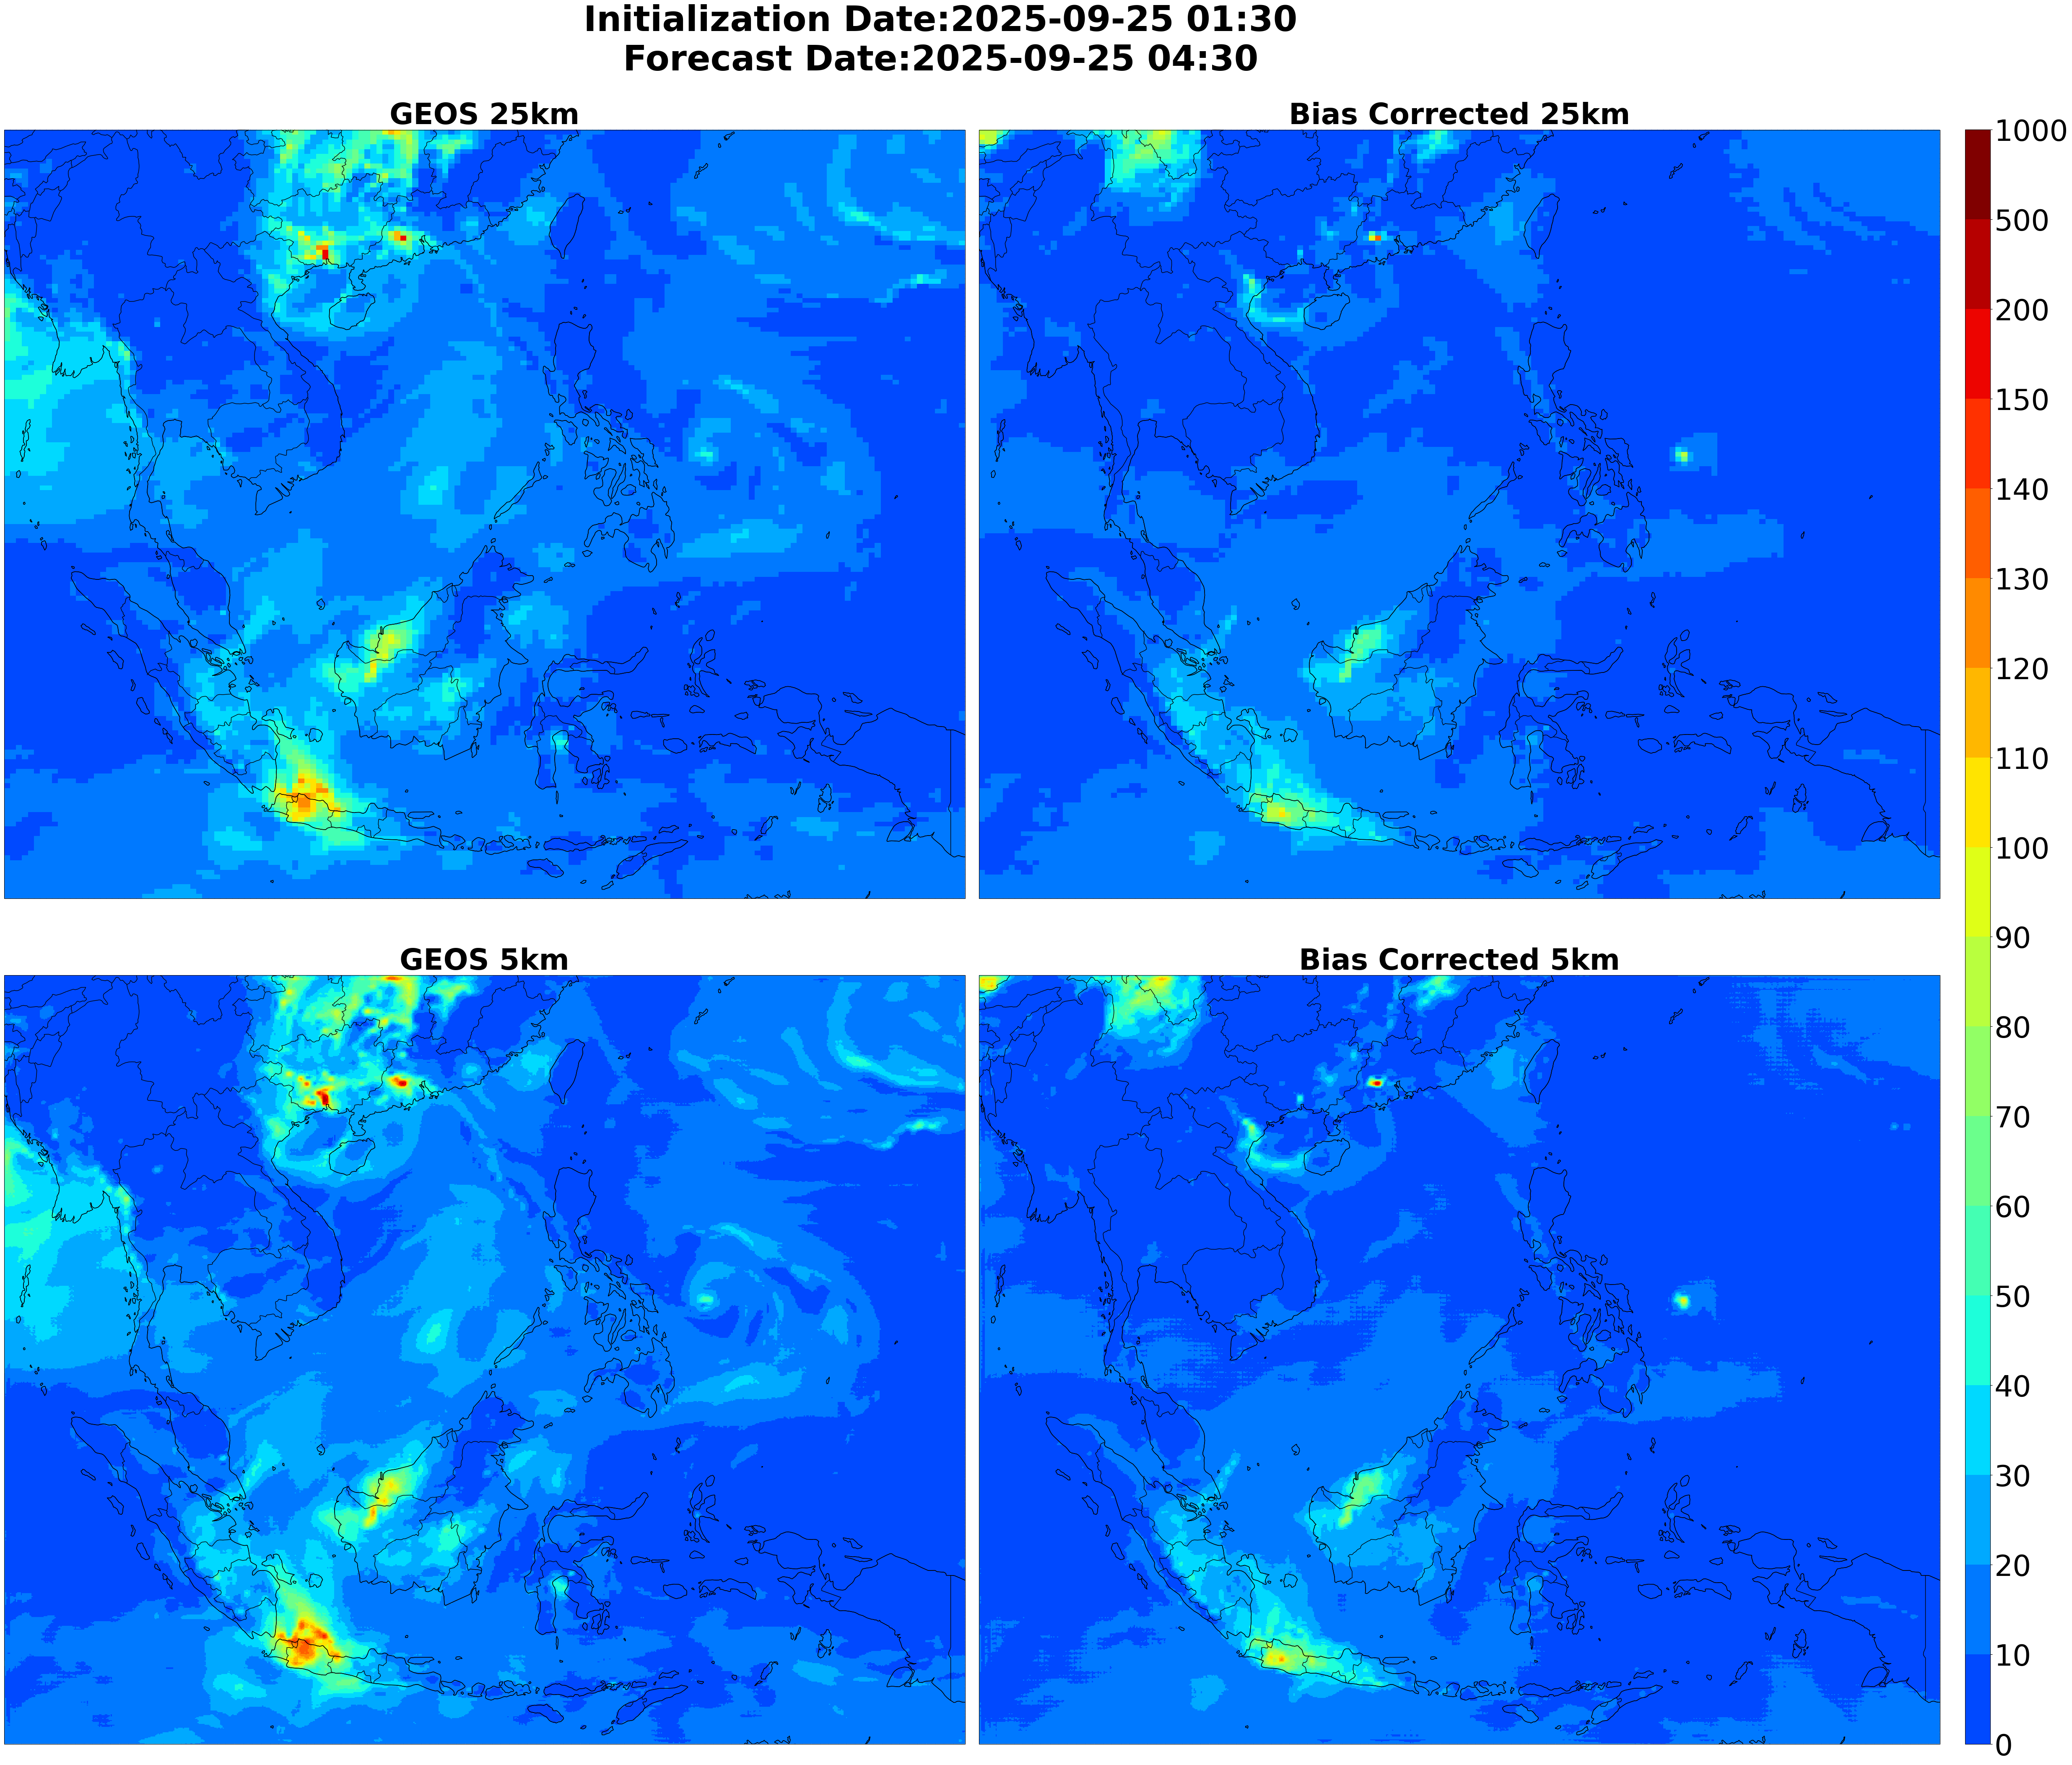

In [15]:
PLOT_DS(ds, out_ds,2) 